# Неделя 4. Среда
## Временные ряды

В этом задании тебе предстоит проанализировать продажи разных категорий товаров. Сначала это стоит сделать для одной категории, потом можно попробовать для других. 

1. Загрузи [датасет](https://community.tableau.com/s/question/0D54T00000CWeX8SAL/sample-superstore-sales-excelxls) и распечатай первые 10 строк. 

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_column', 100)
pd.set_option('display.max_row', 100)
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import cross_val_score
import optuna
from sklearn.model_selection import KFold
from joblib import dump, load

In [13]:
plt.style.use('seaborn-v0_8')

In [14]:
df = pd.read_excel('Sample - Superstore.xls')
df = df[df['Category'] == 'Furniture']
df1 = pd.read_excel('Sample - Superstore.xls')
df1 = df1[df1['Category'] == 'Furniture']

Сделай выбоорку по категории товара (используй популярную категорию: например, `Furniture`) и запиши в переменную `data`. Распечатай первые 10 строк. 

In [15]:
df = pd.DataFrame(df.groupby('Order Date')['Sales'].sum().reset_index())
df.set_index('Order Date', inplace=True)

In [16]:
df.head()

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,879.939


In [17]:
df.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

2. Визуализируй данные:
    * по исходному целевому столбцу (`Sales`)
    * усреднить просуммировать по разным периодам (неделя, месяц, квартал, полугодие)

Text(0.5, 1.0, '6M')

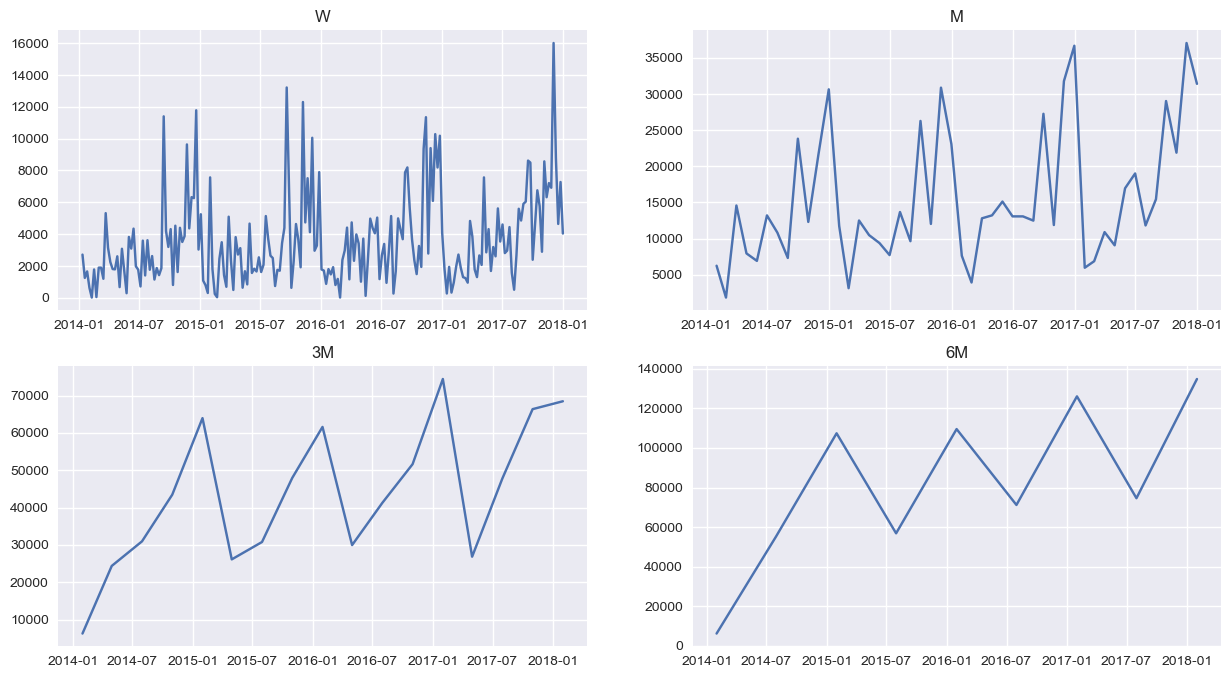

In [18]:
fix, ax = plt.subplots(2, 2, figsize=(15,8))
ax[0,0].plot(df.resample('W').sum())
ax[0,0].set_title('W')
ax[0,1].plot(df.resample('M').sum())
ax[0,1].set_title('M')
ax[1,0].plot(df.resample('3M').sum())
ax[1,0].set_title('3M')
ax[1,1].plot(df.resample('6M').sum())
ax[1,1].set_title('6M')

2.1 В качестве анализа необходимо взять временной ряд по __неделям__, и анализировать __сумму__. 

3. Построй визуализации:
* скользящего среднего


In [19]:
df = df.resample('W').sum()
df

,Sales
Order Date,
2014-01-12,2712.4280
2014-01-19,1250.4730
2014-01-26,1655.9580
2014-02-02,623.6660
2014-02-09,14.5600
...,...
2017-12-03,16008.1720
2017-12-10,8794.4040
2017-12-17,4639.8190


In [20]:
adfuller(df['Sales'])

(-3.444274563579573,
 0.009539026607022119,
 6,
 201,
 {'1%': -3.4633090972761744,
  '5%': -2.876029332045744,
  '10%': -2.5744932593252643},
 3570.1605232384068)

In [21]:
n_window = 1

moving_average_pred = df['Sales'].rolling(window=n_window, closed='left').mean()

moving_average_mae = np.round(mean_absolute_error(df['Sales'][n_window:], moving_average_pred[n_window:]), 2)
moving_average_r2 = np.round(r2_score(df['Sales'][n_window:], moving_average_pred[n_window:]), 2)

'MAE = 2310.23'

'r2 = -0.25'

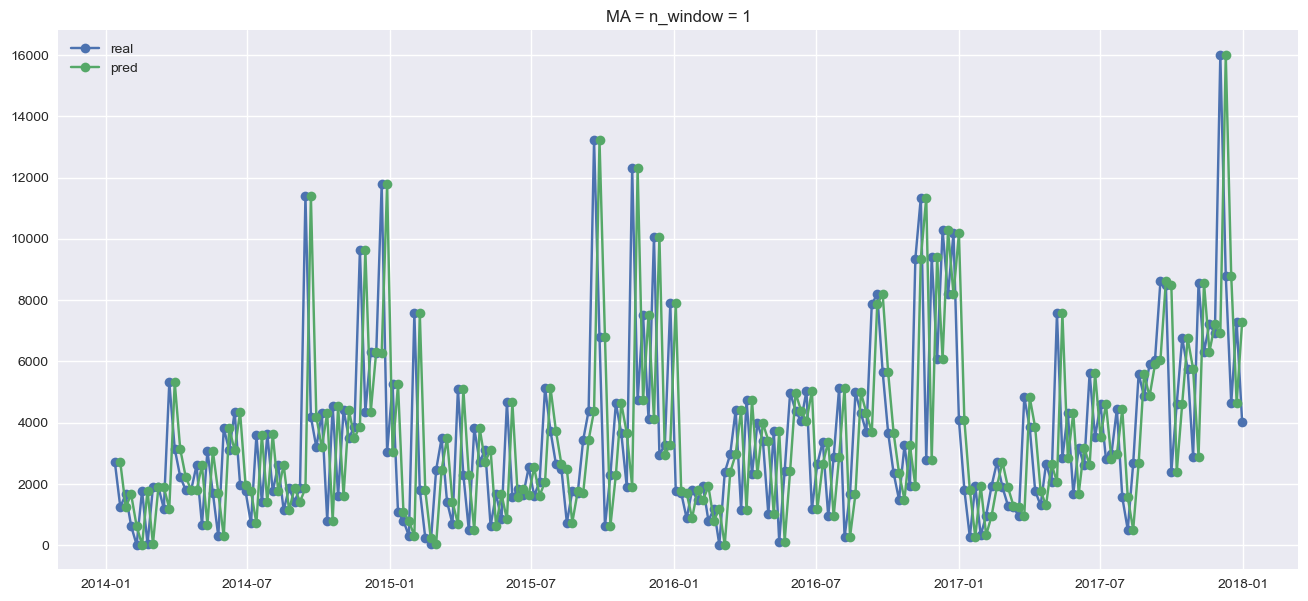

In [22]:
display(f'MAE = {moving_average_mae}')
display(f'r2 = {moving_average_r2}')
plt.figure(figsize=(16,7))
plt.plot(df['Sales'], marker='o', label='real')
plt.plot(moving_average_pred, label='pred', marker='o')
plt.legend()
plt.title(f'MA = n_window = 1');


* взвешенного скользящего среднего


In [23]:
def weighted_moving_average(x, n, weights):
    weights = np.array(weights)
    wmas = x.rolling(n).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True).to_list()
    result = pd.Series(wmas, index=df.index).shift(1)
    return result

In [24]:
n_window = 52

# вес 0.6 для значений этой недели год назад, предыдущие 3 недели, как показатель продаж в этом месяце получают 0,3 и между остальными распределяю 0.1
weights = [0.6] * 1 + [0.1 / 48] * 48 + [0.3 / 3] * 3

weighted_moving_average_pred = weighted_moving_average(df['Sales'], n=n_window, weights=weights)

weighted_moving_average_mae = np.round(mean_absolute_error(df['Sales'][n_window:],weighted_moving_average_pred[n_window:]),2)
weighted_moving_average_r2 = np.round(r2_score(df['Sales'][n_window:],weighted_moving_average_pred[n_window:],),2)

display(f'MAE = {weighted_moving_average_mae}')
display(f'r2 = {weighted_moving_average_r2}')

'MAE = 1868.78'

'r2 = 0.22'

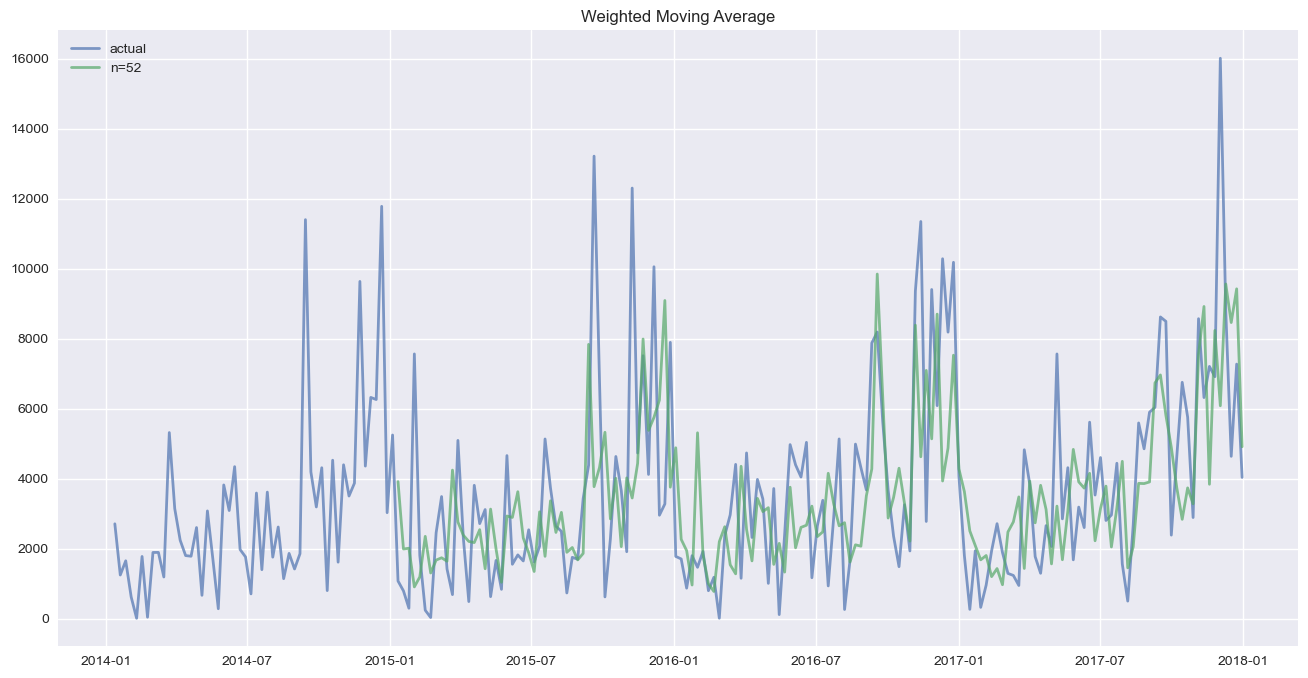

In [25]:
plt.figure(figsize=(16,8))
plt.plot(
    df['Sales'],
    linewidth=2, 
    label='actual', 
    alpha=.7
)

plt.plot(
    weighted_moving_average_pred, 
    linewidth=2, 
    label=f'n={n_window}',
    alpha=.7
)
plt.title('Weighted Moving Average')
plt.legend();

Какие выводы можно сделать по скользящим линиям? Что они показывают?

4. Декомпозируй данные на тренд, сезонность и остатки. 

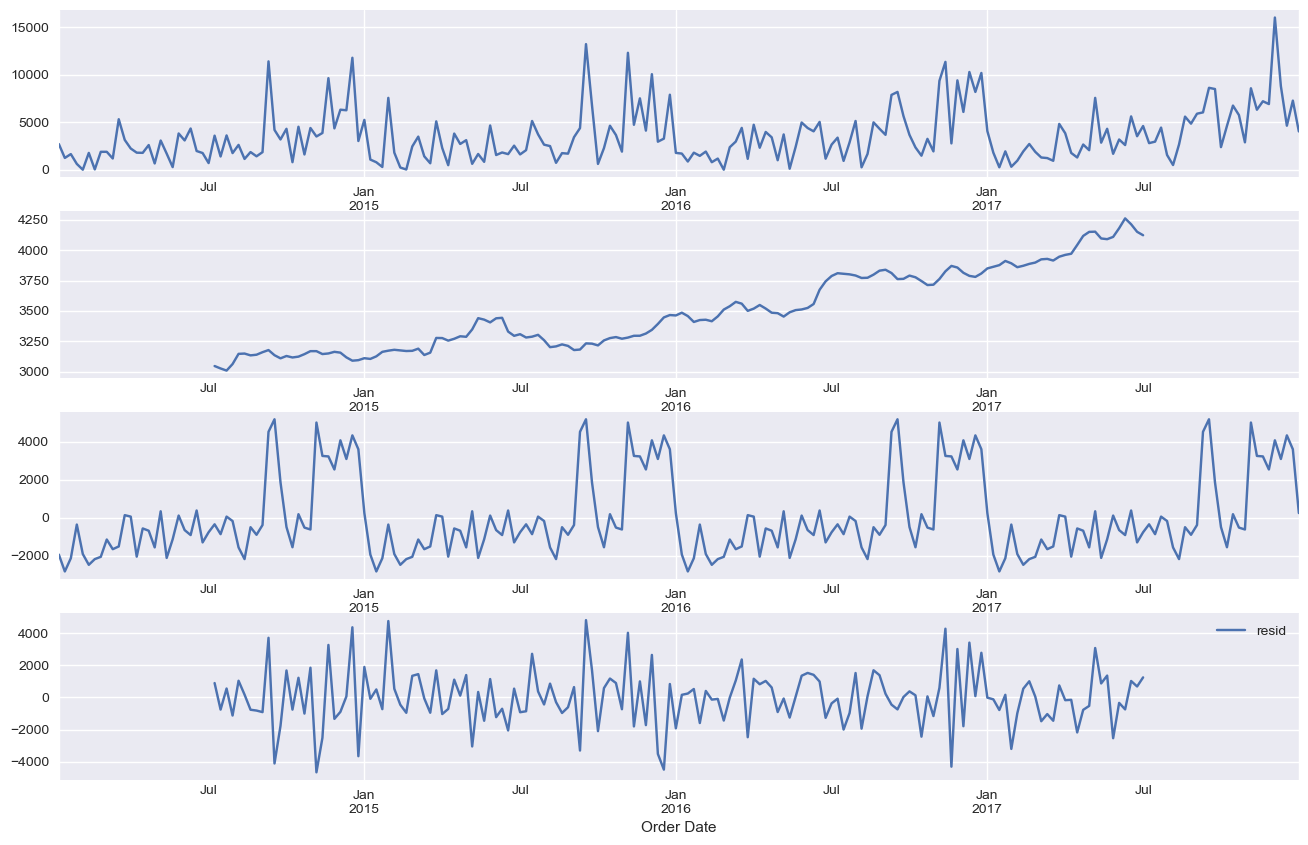

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(16,10))
res = seasonal_decompose(df['Sales'])
res.observed.plot(ax=ax1)
res.trend.plot(ax=ax2)
res.seasonal.plot(ax=ax3)
res.resid.plot(ax=ax4)
plt.legend()
plt.show();

# ❓
Прокомментируй графики: какой вывод можно сделать? Есть ли в данных сезонность? Какой тренд преобладает? Какого масштаба ошибки по сравнению со значениями основного временного ряда?

Присутствует стабильный растущий тренд  
Вплески продаж наблюдаются скорее всего в черную пятницу + предновогодние месяца
средние ошибки в районе 2 тысяч

5. Построй графики автокорреляционной функции и частичной автокорреляционной функции. 

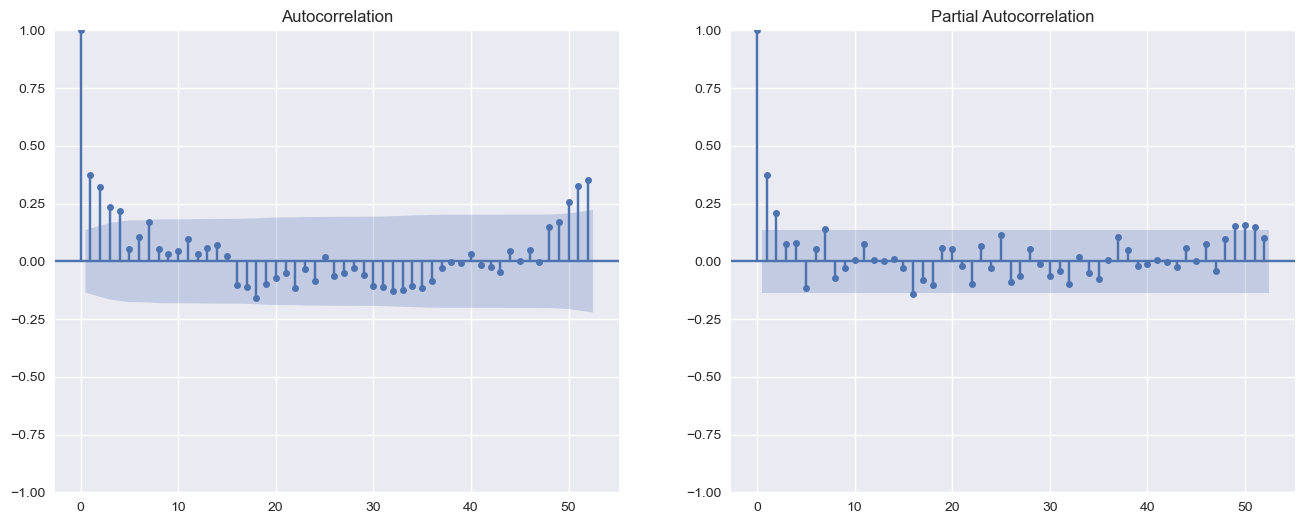

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
n_lags = 52
acf = plot_acf(df['Sales'], ax=ax1, lags=n_lags)
pacf = plot_pacf(df['Sales'], ax=ax2, lags=n_lags)

# ❓
Какие выводы можно сделать на основе этих графиков?

> ответ тут

6. Постройте и визуализируйте модель класса ARIMA

In [28]:
data_train = df[df['Sales'].index.year < 2017]
data_test = df[df['Sales'].index.year >= 2017]

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(data_train, order=(0, 0, 0), seasonal_order=(2, 0, 0, 52)).fit()
dump(model, 'sarimax_model.joblib')

model_pred_train = model.fittedvalues # предсказания для train

model_pred = model.forecast(len(data_test)) # Предсказание для тестовых точек + еще на 3 сезона вперед
model_pred_test, model_pred_future = model_pred[:len(data_test)], model_pred[len(data_test):] # Делим элементы из тестовой выборки и будущий периож

ar_mae = round(mean_absolute_error(data_test, model_pred_test), 3)
ar_r2 = round(r2_score(data_test, model_pred_test), 3)
print(f'mae = {ar_mae}')
print(f'r2 = {ar_r2}')

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03783D+01    |proj g|=  1.69724D+00

At iterate    5    f=  9.46617D+00    |proj g|=  5.07258D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8      9      1     0     0   1.222D-05   9.466D+00
  F =   9.4660946666653611     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
mae = 1751.834
r2 = 0.349


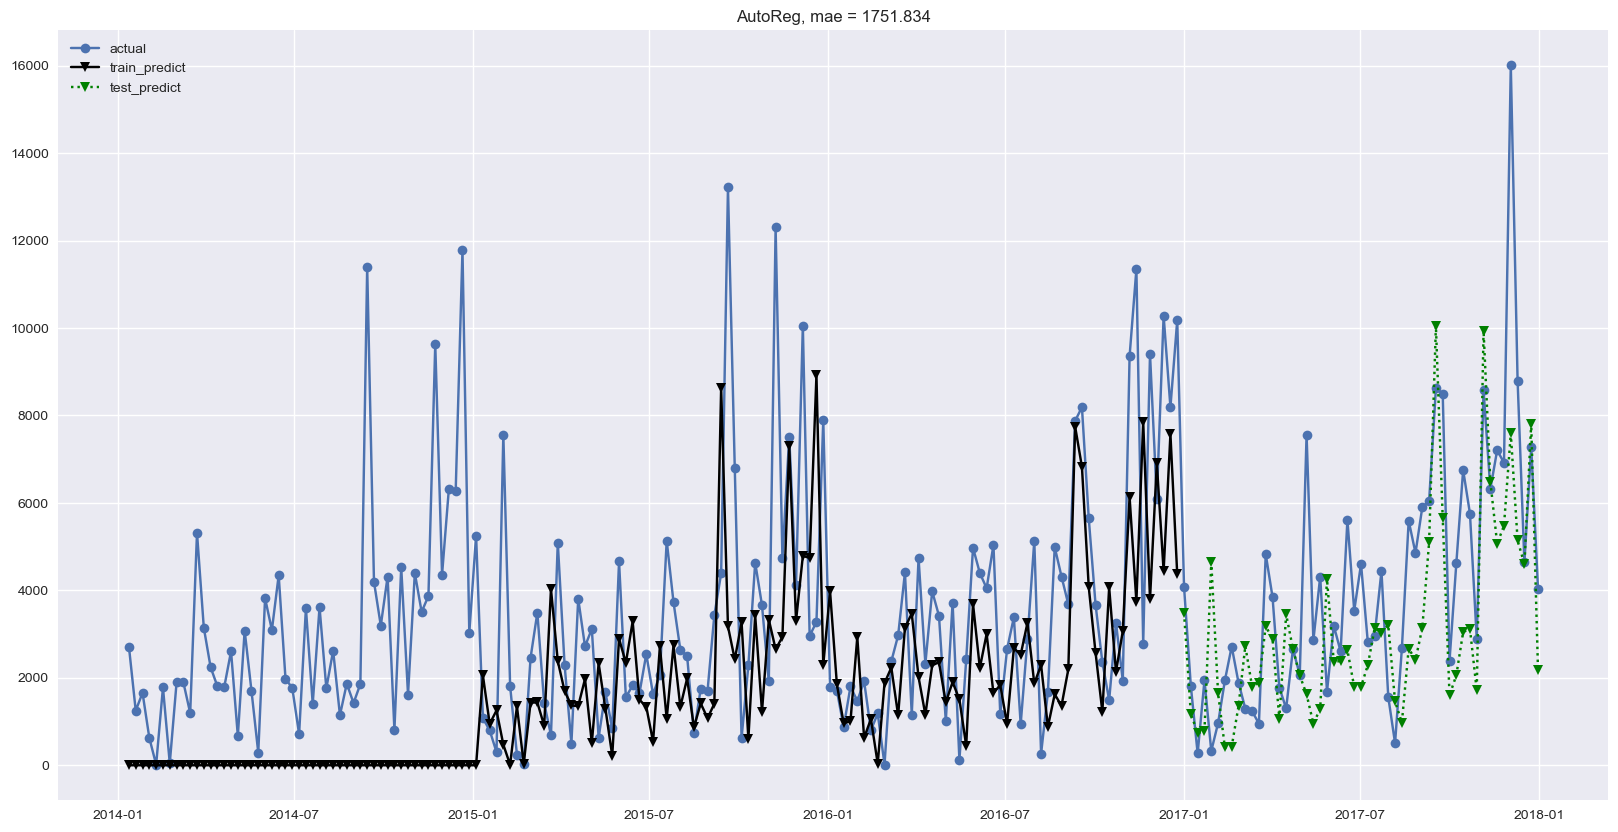

In [30]:
plt.figure(figsize=(20, 10))
plt.plot(df['Sales'], label='actual', marker='o')
plt.plot(model_pred_train, marker='v', color='k', label='train_predict')
plt.plot(pd.concat((model_pred_test, model_pred_future)), marker='v', color='g', label='test_predict', linestyle=':')
plt.legend()
plt.title(f'AutoReg, mae = {ar_mae}');

7. Постройте и визуализируйте модель prophet. Попробуйте подобрать оптимальные параметры

In [31]:
from prophet import Prophet

In [32]:
data_prophet = df['Sales'].reset_index().rename(columns={'Order Date': 'ds', 'Sales': 'y'})


data_train = data_prophet[data_prophet['ds'].dt.year < 2017]
data_test = data_prophet[data_prophet['ds'].dt.year >= 2017]

In [33]:
model = Prophet()
model.fit(data_train)
dump(model, 'prophet_model.joblib')

seasonality_period = 52 
number_of_future_predicted_points = 3 * seasonality_period # Предскажем на три периода в тесте + пару периодов наперед

future = model.make_future_dataframe(periods=number_of_future_predicted_points, freq='W')
forecast = model.predict(future)

11:19:13 - cmdstanpy - INFO - Chain [1] start processing
11:19:13 - cmdstanpy - INFO - Chain [1] done processing


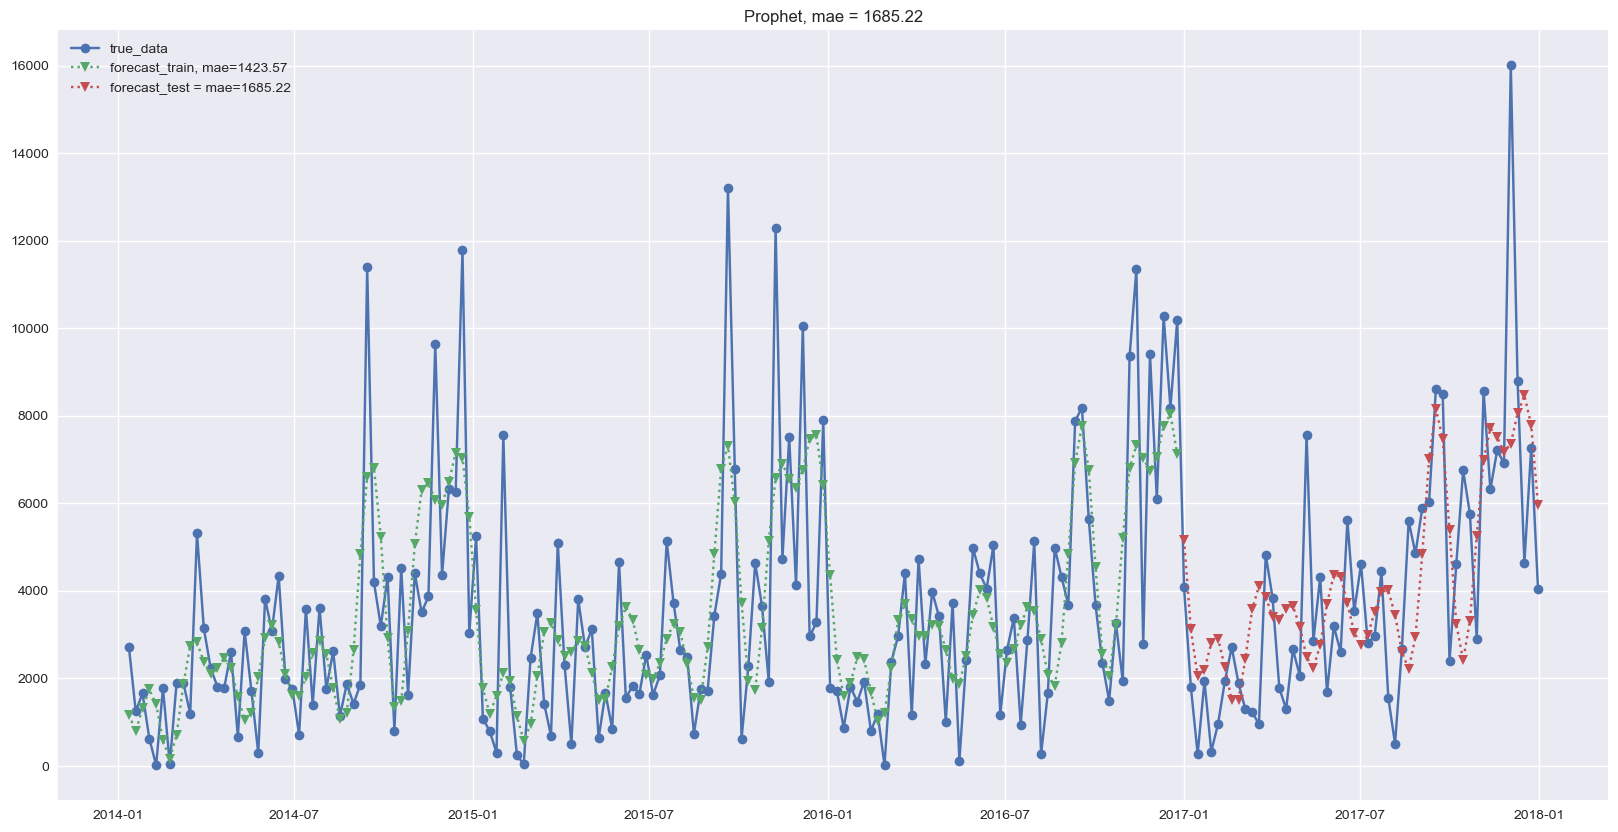

In [34]:
forecast_train = forecast[:-number_of_future_predicted_points]
forecast_test = forecast[-number_of_future_predicted_points: -number_of_future_predicted_points + len(data_test)] # Тестовый
forecast_future = forecast[-number_of_future_predicted_points + len(data_test):] # Будущий период


prophet_mae_train = np.round(mean_absolute_error(data_train['y'], forecast_train['yhat']), 2)
prophet_mae_test = np.round(mean_absolute_error(data_test['y'], forecast_test['yhat']), 2)

plt.figure(figsize=(20, 10))
plt.plot(df['Sales'], label='true_data', marker='o')

plt.plot(forecast_train['ds'], forecast_train['yhat'], marker='v', linestyle=':', label=f'forecast_train, mae={prophet_mae_train}')
plt.plot(forecast_test['ds'], forecast_test['yhat'], marker='v', linestyle=':', label=f'forecast_test = mae={prophet_mae_test}')

# plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.15)
# plt.xticks(rotation=45)

plt.title(f'Prophet, mae = {prophet_mae_test}');
plt.legend();

8. Примени регрессионные модели (случайный лес или градиентный бустинг) для прогнозирования целевой величины.
   * Пример есть в демо

In [35]:
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [36]:
data_train = df[df['Sales'].index.year < 2017]
data_test = df[df['Sales'].index.year >= 2017]

In [37]:
# Создаем фичи на основе лагов
def create_lag_features(df, lags=[1, 2]):
    for lag in lags:
        df[f'lag_{lag}'] = df['Sales'].shift(lag)
    return df

# Применяем функцию для создания фичей
data_train = create_lag_features(data_train)
data_test = create_lag_features(data_test)

# Удаляем строки с NaN, появившиеся после создания лагов
data_train = data_train.dropna()
data_test = data_test.dropna()

# Разделяем фичи и целевую переменную
X_train = data_train.drop(columns=['Sales'])
y_train = data_train['Sales']
X_test = data_test.drop(columns=['Sales'])
y_test = data_test['Sales']


In [38]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 500, step=10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'depth': trial.suggest_int('depth', 2, 10),
        'subsample': trial.suggest_uniform('subsample', 0.3, 0.95),
        'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.3, 0.95),
        'random_state': 42,
        'loss_function': 'MAE',
        'logging_level': 'Silent'
    }
    
    model = CatBoostRegressor(**params)
    cv = KFold(n_splits=3, random_state=42, shuffle=True)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
    mae = -scores.mean()
    
    return mae

# Создание и запуск оптимизации с помощью Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_mae = study.best_value

print(f"Лучшие параметры: {best_params}")
print(f"Лучшее значение MAE: {best_mae}")


[I 2024-07-18 11:19:16,448] A new study created in memory with name: no-name-9863647c-2d71-4580-99dc-1f3772487b01
[I 2024-07-18 11:19:16,648] Trial 0 finished with value: 1829.9775578592983 and parameters: {'n_estimators': 360, 'learning_rate': 0.012471315777852945, 'depth': 3, 'subsample': 0.9248118685212938, 'colsample_bylevel': 0.54732655462841}. Best is trial 0 with value: 1829.9775578592983.
[I 2024-07-18 11:19:16,907] Trial 1 finished with value: 1868.7405545081708 and parameters: {'n_estimators': 210, 'learning_rate': 0.014326704941353212, 'depth': 9, 'subsample': 0.6716194266730042, 'colsample_bylevel': 0.802782455471459}. Best is trial 0 with value: 1829.9775578592983.
[I 2024-07-18 11:19:16,969] Trial 2 finished with value: 1834.632506642624 and parameters: {'n_estimators': 470, 'learning_rate': 0.07546349115511852, 'depth': 3, 'subsample': 0.7383677116972569, 'colsample_bylevel': 0.32446347211152005}. Best is trial 0 with value: 1829.9775578592983.
[I 2024-07-18 11:19:17,026

Лучшие параметры: {'n_estimators': 450, 'learning_rate': 0.020107505273996386, 'depth': 5, 'subsample': 0.6714992945444287, 'colsample_bylevel': 0.31211245090371764}
Лучшее значение MAE: 1822.0308138524035


In [39]:
model = CatBoostRegressor(**best_params)
model.fit(X_train, y_train)
dump(model, 'catboost_model.joblib')

0:	learn: 2753.8838570	total: 256us	remaining: 115ms
1:	learn: 2748.8533967	total: 721us	remaining: 162ms
2:	learn: 2745.9486157	total: 802us	remaining: 120ms
3:	learn: 2745.9485917	total: 830us	remaining: 92.6ms
4:	learn: 2735.5780119	total: 1.13ms	remaining: 100ms
5:	learn: 2730.8449055	total: 1.17ms	remaining: 86.8ms
6:	learn: 2730.8448500	total: 1.2ms	remaining: 76ms
7:	learn: 2730.8447967	total: 1.22ms	remaining: 67.6ms
8:	learn: 2726.2838179	total: 1.31ms	remaining: 64.4ms
9:	learn: 2722.7494817	total: 1.41ms	remaining: 62.2ms
10:	learn: 2722.7494332	total: 1.45ms	remaining: 57.8ms
11:	learn: 2722.7493866	total: 1.48ms	remaining: 53.9ms
12:	learn: 2716.1604522	total: 1.58ms	remaining: 53ms
13:	learn: 2716.1603554	total: 1.6ms	remaining: 50ms
14:	learn: 2716.1602623	total: 1.62ms	remaining: 47.1ms
15:	learn: 2716.1601729	total: 1.64ms	remaining: 44.6ms
16:	learn: 2711.2110516	total: 1.78ms	remaining: 45.3ms
17:	learn: 2709.3554887	total: 1.82ms	remaining: 43.8ms
18:	learn: 2705.18

['catboost_model.joblib']

Mean Absolute Error: 1755.0059992043325
R^2 Score: 0.3173298113868869


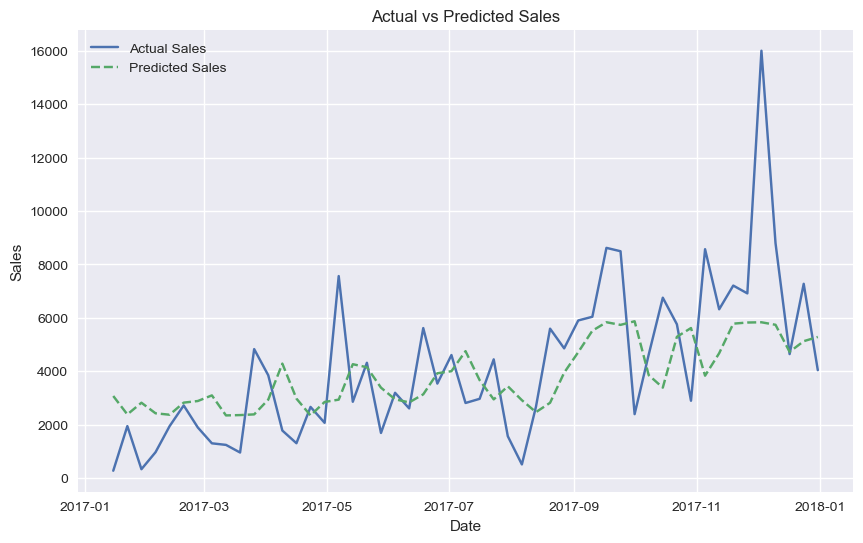

In [40]:
# Делаем предсказания на тестовых данных
y_pred = model.predict(X_test)

# Оцениваем качество модели
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}')

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(data_test.index, y_test, label='Actual Sales')
plt.plot(data_test.index, y_pred, label='Predicted Sales', linestyle='--')
plt.legend()
plt.title('Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()


9. Создайте Streamlit-приложение, в которое пользователь сможет загрузить свой файл с временным рядом, и получить результат предсказания, а так же метрики и интерпретацию результатов

10*. Если останется время, можно попробовать дополнительно одну из библиотек: 
* [Darts](https://habr.com/ru/articles/659405/)
* [Merlion](https://habr.com/ru/companies/sportmaster_lab/articles/792318/)
* [tsfresh](https://tsfresh.readthedocs.io/en/latest/)
* [Kats](https://github.com/facebookresearch/Kats)
* [autots](https://winedarksea.github.io/AutoTS/build/html/source/tutorial.html)

In [219]:
from merlion.utils import UnivariateTimeSeries
from merlion.models.forecast.smoother import MSES
from merlion.models.forecast.arima import Arima
from merlion.transform.resample import TemporalResample
from merlion.utils import TimeSeries
from merlion.evaluate.forecast import ForecastMetric


In [222]:
uts = UnivariateTimeSeries.from_pd(df["Sales"])
train, test = uts.bisect("2017", t_in_left=False)

<img src="https://icons.iconarchive.com/icons/icons8/windows-8/256/Programming-Github-icon.png" width=32 /> Сохрани файл для __github__. 
